# Fugu Example Notebook - Streaming Arithmetic in Fugu

Brad Aimone, 3/10/2022.

This notebook shows how Fugu can be used to generate circuits that perform basic streaming arithmetic functions, including addition, subtraction, inversion.  The goal of this notebook is to show how simple circuits can be described in Fugu as bricks, and illustrate how these bricks can be combined to perform more complex functions.

The examples shown here are described in the ICRC 2021 paper by Aimone et al

### Neuron Coding Scheme

The examples in this notebook describe circuits that use inputs which are encoded using a little-endian-in-time (LEIT) coding scheme.  LEIT coding is simple - think of a binary description of a number (19 = 10011), flip it around so the least significant bit is first (19 => 11001), and then have the input neuron spike at the first, second, and fifth timesteps. 

## Step 0: Setup
First, we need to import Fugu and other relevant libraries

In [1]:
import networkx as nx
import numpy as np
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend
%load_ext autoreload
%autoreload 2

## Brick 1: Adder brick

This is a brick to perform the streaming adder shown in the image below

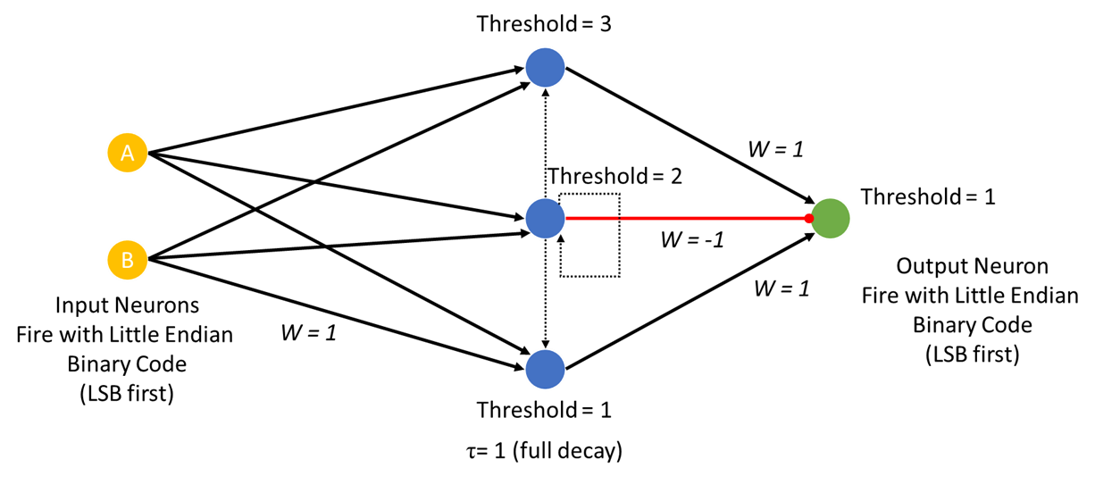

For intuition of how this circuit functions, consider that if the least significnt bit of the two inputs each are '1', we want a '0' for the first bit of the output, but we need the carry bit to contribute a '1' to the addition at the next time-step.  

This circuit requires very simple neurons, with no leak or complicated weights involved.  The circuit does use delays to align the carry bits with the next additions, and it uses inhibition to cancel out bits.  

### Brick Design

The Fugu brick for the adder is shown below.  streaming_adder inherits from the Brick class.  

#### Neural circuit
Most of the custom brick code consists of laying out the circuit illustrated above. The neural circuit is described using conventions motivated by a NetworkX graph; we add neurons as 'nodes' while assigning a name and define key attributes (threshold, decay, firing probability, starting potential), and we add synapses as directed 'edges' by assigning the nodes it connects (to and from) and define key attributes (weight and delay)

#### Control Nodes
Additionally, the brick includes two control nodes.  The control nodes typically connect to the control nodes of upstream bricks and are used to signal to a downstream brick that an input is arriving at the circuit.  

By convention, all bricks need to have control nodes that illustrate when a computation will start and stop, as a downstream brick may require this information for its computation.

Later examples will illustrate how these control nodes are used

In [2]:
class streaming_adder(Brick):
    
    """
    streaming adder function. 
    Brad Aimone
    jbaimon@sandia.gov
    
    """
    
    def __init__(self, name=None):
        super().__init__()
        self.is_built = False
        self.dimensionality = {'D': 2}
        self.name = name
        self.supported_codings = ['binary-L']
        
    def build(self, graph, dimensionality, control_nodes, input_lists, input_codings):
        """
        Build streaming adder brick. 

        Arguments:
            + graph - networkx graph to define connections of the computational graph
            + dimensionality - dictionary to define the shapes and parameters of the brick
            + control_nodes - dictionary of lists of auxillary networkx nodes.  Excpected keys: 'complete' - A list of neurons that fire when the brick is done
            + input_lists - list of nodes that will contain input
            + input_coding - list of input coding formats

        Returns:
            + graph of a computational elements and connections
            + dictionary of output parameters (shape, coding, layers, depth, etc)
            + dictionary of control nodes ('complete')
            + list of output
            + list of coding formats of output
        """
        
        if len(input_codings) != 2:
            raise ValueError("adder takes in 2 input on size n")
            
        output_codings = [input_codings[0]]
        
        new_complete_node_name = self.name + '_complete'
        new_begin_node_name = self.name + '_begin'
        
        graph.add_node(new_begin_node_name, index = -2, threshold = 0.0, decay =0.0, p=1.0, potential=0.0)
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = .9,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)
        

        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name, weight=0.5, delay=3)
        graph.add_edge(control_nodes[1]['complete'], new_complete_node_name, weight=0.5, delay=3)

        graph.add_edge(control_nodes[0]['begin'], new_begin_node_name, weight=1.0, delay=2)

        complete_node = new_complete_node_name
        begin_node = new_begin_node_name
        
     
        l = len(input_lists[0])
        
        #nodes
        graph.add_node(self.name + 'add', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry0', threshold=1.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry1', threshold=2.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'out', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        #edges
        graph.add_edge(input_lists[0][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry1', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'carry0', self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'add', self.name + 'out', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'out', weight=-1.0, delay=1)
        graph.add_edge(self.name + 'carry1', self.name + 'out', weight=1.0, delay=1)
        
        self.is_built=True
        
        output_lists = [[self.name + 'out']]
        
        return (graph, self.dimensionality, [{'complete': complete_node, 'begin': begin_node}], output_lists, output_codings)
    

## Brick 2: Temporal Shift brick

The below brick performs a temporal bit shift of an input. 

In binary LEIT spike coding, this temporal shift (delaying by +1) equates to a bit shift operation in binary (x<<a --> equivalent to  x 2**a)

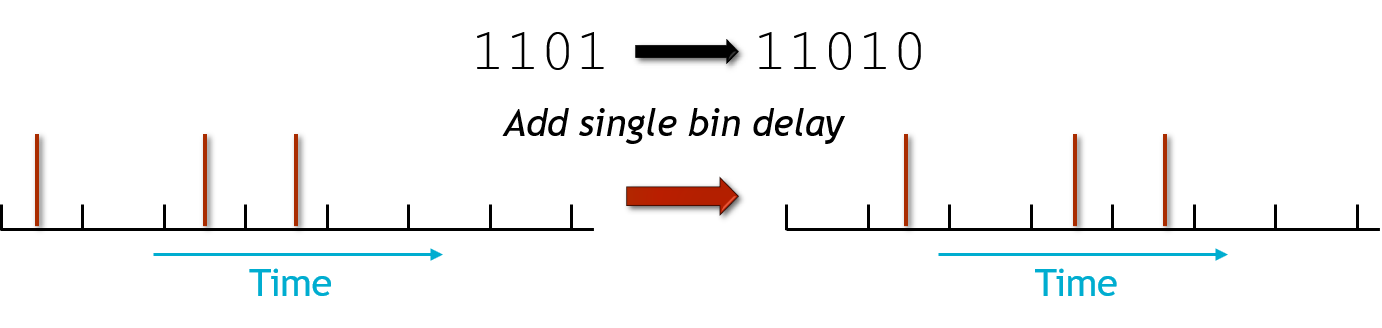

As can be seen here, the brick in this case is simply an output neuron that is delaying an input neuron's activity by a number of timesteps.  The delay is provided as an input to the brick when the scaffold is constructed later.

In [3]:
class temporal_shift(Brick):
    
    """
    temporal shift function. 
    Brad Aimone
    jbaimon@sandia.gov
    
    """
    
    def __init__(self, name=None, shift_length = 1):
        super().__init__()
        self.is_built = False
        self.dimensionality = {'D': 2}
        self.name = name
        self.supported_codings = ['binary-L']
        self.shift_length = shift_length
        
    def build(self, graph, dimensionality, control_nodes, input_lists, input_codings):
        """
        Build bit shift brick. 

        Arguments:
            + graph - networkx graph to define connections of the computational graph
            + dimensionality - dictionary to define the shapes and parameters of the brick
            + control_nodes - dictionary of lists of auxillary networkx nodes.  Excpected keys: 'complete' - A list of neurons that fire when the brick is done
            + input_lists - list of nodes that will contain input
            + input_coding - list of input coding formats

        Returns:
            + graph of a computational elements and connections
            + dictionary of output parameters (shape, coding, layers, depth, etc)
            + dictionary of control nodes ('complete')
            + list of output
            + list of coding formats of output
        """
        
        if len(input_codings) != 1:
            raise ValueError("bit_shift takes in 1 input on size n")
            
        output_codings = [input_codings[0]]
        
        new_complete_node_name = self.name + '_complete'
        new_begin_node_name = self.name + '_begin'
        
        graph.add_node(new_begin_node_name, index = -2, threshold = 0.0, decay =0.0, p=1.0, potential=0.0)
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = 0.0,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)
        

        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name, weight=1.0, delay=self.shift_length)
        graph.add_edge(control_nodes[0]['begin'], new_begin_node_name, weight=1.0, delay=1)

        complete_node = new_complete_node_name
        begin_node = new_begin_node_name
        
        l = len(input_lists[0])
        
        #nodes
        graph.add_node(self.name + 'out', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        #edges
        graph.add_edge(input_lists[0][0], self.name + 'out', weight=1.0, delay=self.shift_length)
        
        self.is_built=True
        
        output_lists = [[self.name + 'out']]
        
        return (graph, self.dimensionality, [{'complete': complete_node, 'begin':begin_node}], output_lists, output_codings)
    

## Brick 3: Inverter brick

The below brick performs an binary-inversion of an input in LEIT coding. This is basically flipping '0'->'1' and '1'->'0'

The circuit here uses 'begin' control node from the input brick to drive a neuron ('active') which is on continuously for the period of time of the inversion, until shut off by the 'complete' control node from the input brick.  The input neuron inhibits the output neuron, while 'active' attempts to activates it.  The combination of these two provides the inverted calculation.


In [4]:
class inverter(Brick):
    
    """
    inverter function. 
    Brad Aimone
    jbaimon@sandia.gov
    
    """
    
    def __init__(self, name=None):
        super().__init__()
        self.is_built = False
        self.dimensionality = {'D': 2}
        self.name = name
        self.supported_codings = ['binary-L']

    def build(self, graph, dimensionality, control_nodes, input_lists, input_codings):
        """
        Build inverter brick. 

        Arguments:
            + graph - networkx graph to define connections of the computational graph
            + dimensionality - dictionary to define the shapes and parameters of the brick
            + control_nodes - dictionary of lists of auxillary networkx nodes.  Excpected keys: 'complete' - A list of neurons that fire when the brick is done
            + input_lists - list of nodes that will contain input
            + input_coding - list of input coding formats

        Returns:
            + graph of a computational elements and connections
            + dictionary of output parameters (shape, coding, layers, depth, etc)
            + dictionary of control nodes ('complete')
            + list of output
            + list of coding formats of output
        """
        
        if len(input_codings) != 1:
            raise ValueError("inverter takes in 1 input on size n")
            
        output_codings = [input_codings[0]]
        
        new_complete_node_name = self.name + '_complete'
        new_begin_node_name = self.name + '_begin'
        
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = 0.0,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)
        graph.add_node(new_begin_node_name, index = -2, threshold = 0.0, decay =0.0, p=1.0, potential=0.0)

        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name, weight=1.0, delay=2)
        graph.add_edge(control_nodes[0]['begin'], new_begin_node_name, weight=1.0, delay=2)

        complete_node = new_complete_node_name
        begin_node = new_begin_node_name
        
        l = len(input_lists[0])
        
        #nodes
        graph.add_node(self.name + 'out', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'active', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        #edges
        graph.add_edge(input_lists[0][0], self.name + 'out', weight=-1.0, delay=2)
        graph.add_edge(self.name+'active', self.name + 'out', weight=1.0, delay=1)
        graph.add_edge(self.name+'active', self.name + 'active', weight=1.0, delay=1)
        graph.add_edge(control_nodes[0]['begin'], self.name + 'active', weight=1.0, delay=1)
        graph.add_edge(control_nodes[0]['complete'], self.name + 'active', weight=-10.0, delay=2)
        
        self.is_built=True
        
        output_lists = [[self.name + 'out']]
        
        return (graph, self.dimensionality, [{'complete': complete_node, 'begin': begin_node}], output_lists, output_codings)


## Example 1: Simple addition

Okay, now we have defined our three bricks (streaming_adder, temporal_shift, and inverter).  We're going to start with a simple addition problem.  

We are going to use the base Fugu 'Vector_Input' brick to describe an input, whereby we convert an numpy array to a series of spikes.

To construct the example, we will put together three bricks: one for each input, and the streaming adder output. 

The 'add_brick' call requires two main inputs: the brick that is going to be added (in this case 'streaming_adder') and any arguments for that brick, and which bricks are inputs.  As the example shows, the inputs are a list of tuples provided  *in the order that the brick will use them*.  Each tuple consists of the ([index of the input brick in the scaffold], [output neuron of the input brick]).  So in this case, the streaming adder will use output neuron '0' from both the '0' and '1' bricks in the scaffold.

We further identify the snn_Backend() as the simulator with which we will test the brick, and then we will flag all of the neurons to be recorded.  

The output of this example is verbose, and we will see the final output as a list of timesteps over which different neurons fire.  In this case, neurons '2' and '5' are input neurons, and neuron '11' is the main output neuron of the example

In [5]:
# Simple addition example

scaffold = Scaffold()

# For addition, what we want to do is create a Scaffold taking two inputs and the adder brick
a=[1, 1, 0, 1, 1, 0, 1, 1]
b=[1, 1, 0, 1, 1, 0, 1, 1]
a=[1, 1]
b=[0, 1]
scaffold.add_brick(Vector_Input(np.array([a]), coding='binary-L', name='Input0', time_dimension = True), 'input' )
scaffold.add_brick(Vector_Input(np.array([b]), coding='binary-L', name='Input1', time_dimension = True), 'input' )
scaffold.add_brick(streaming_adder(name='adder1_'), [(0,0), (1, 0)], output=True)

scaffold.lay_bricks()
scaffold.summary(verbose=1)

backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(30)
print(result)



Scaffold is built: True
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: Input0-0
Brick Name: Input0
{'tag': 'Input0-0', 'name': 'Input0', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x000001CBCF5C7518>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input0-0:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 2)], 'output_coding': 'binary-L', 'layer': <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001CBCC2BF978>>, 'D': 0}, 'control_nodes': [{'complete': 'Input0-0:complete', 'begin': 'Input0-0:begin'}]}
Brick is built: True


Brick No.: 1
Brick Tag: Input1-1
Brick Name: Input1
{'tag': 'Input1-1', 'name': 'Input1', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x000001CBCF5C7630>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input1-1:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 2)], 'output_c

We can visualize the spike raster as follows.  The first six neurons are the inputs, the following five neurons are the adder neurons

In [6]:
import matplotlib.pyplot as plot

result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plot.yticks(np.arange(12), ['Input 0 - begin', 'Input 0 - complete', 'Input 0 - signal', 'Input 1 - begin', 'Input 1 - complete', 'Input 1 - signal', 'Adder - begin', 'Adder - complete', 'Adder - Add', 'Adder - Carry 0', 'Adder - Carry 1', 'Output'])
plot.show()


<Figure size 640x480 with 1 Axes>

## Example 2: Scalar multiplication

This adder can then be assembled serially to provide a scalar multiplication (y = a * x).  Here, we recognize that performing long binary multiplciation of LEIT numbers amounts to simply adding the number 'x' with a series of bit shifted versions of x corresponding to the binary entries of a.  

y = a * x = sum(x, x<<k for all a_k=1), where a_k are the bitwise elements of a

This can be likely be turned into a brick itself, but is just listed as a scaffold below

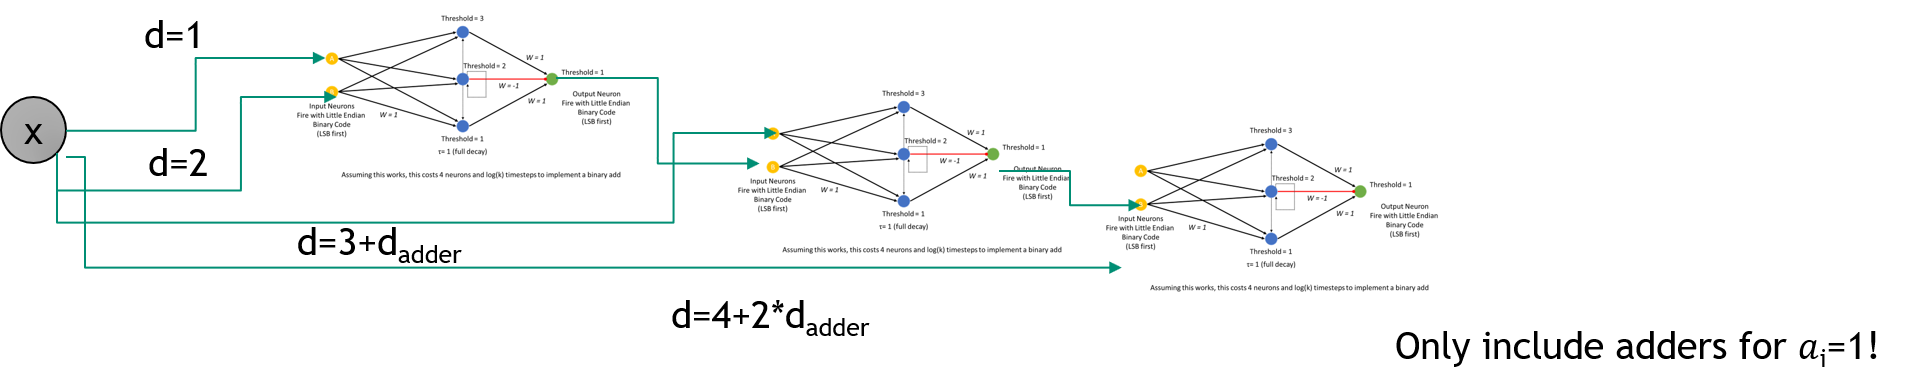

In [7]:
# Scalar multiplication example

scaffold = Scaffold()

alpha = .3125
bit_length = 8
# Convert alpha to little-endian binary
a1=bin(int(alpha*2**bit_length))[2:].zfill(bit_length)
a1=a1[::-1]
print(a1)


# For scalar multiplication, what we want to do is create a Scaffold taking the original input, x, and a zeros input
# 
# This is inefficient, but we will bit shift x to all possible stages.  But we will use the zeros input for each adder who place entry in the scalar is zero

scaffold.add_brick(Vector_Input(np.array([[0, 1, 1, 0, 1, 0, 0, 0]]), coding='binary-L', name='Input0', time_dimension = True), 'input' )
scaffold.add_brick(Vector_Input(np.array([[0, 0, 0, 0, 0, 0, 0, 0]]), coding='binary-L', name='Input_zeros', time_dimension = True), 'input' )

for i in range(1, bit_length):
    # Create a bit shifted version of 'x' for each of the place values of alpha
    scaffold.add_brick(temporal_shift(name='shift'+str(i)+'_', shift_length=1+3*(i-1)), [(0,0)], output=True)    

for i in range(1,bit_length):
    if(i==1):
        # First adder potentially takes in 'x' and 'x<<1'  Need to check if both are used; otherwise pass in zeros
        if(a1[i-1]=='1'):
            in_1=0
        else:
            in_1=1 # First place of scalar is empty, so pass in zeros
    else:
        # All other adders use previous adder as an input
        in_1=bit_length-1+i # 7+i
    if(a1[i]=='1'):
        # For each adder, check if element = 1, otherwise pass in zero as input
        in_2=1+i
    else:
        in_2=1
        
    #print(i, in_1, in_2)
    scaffold.add_brick(streaming_adder(name='adder_'+str(i)+'_'), [(in_1,0), (in_2, 0)], output=True)


scaffold.lay_bricks()
scaffold.summary(verbose=1)

00001010
Scaffold is built: True
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: Input0-3
Brick Name: Input0
{'tag': 'Input0-3', 'name': 'Input0', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x000001CBCF5C7550>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input0-3:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 8)], 'output_coding': 'binary-L', 'layer': <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001CBCC2BF978>>, 'D': 0}, 'control_nodes': [{'complete': 'Input0-3:complete', 'begin': 'Input0-3:begin'}]}
Brick is built: True


Brick No.: 1
Brick Tag: Input_zeros-4
Brick Name: Input_zeros
{'tag': 'Input_zeros-4', 'name': 'Input_zeros', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x000001CBD02EB780>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input_zeros-4:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'

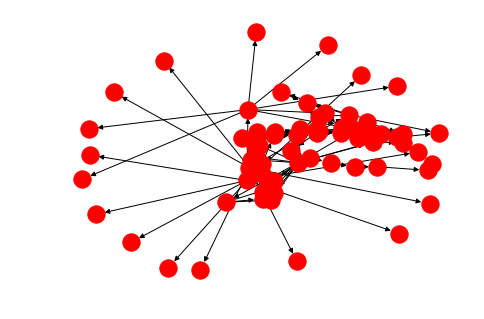

In [8]:
nx.draw(scaffold.graph)

Here, we will not show the verbose version of the code and just the outputs of the neurons in the circuit.

In [9]:
backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(30)
print(result)

    time  neuron_number
0    0.0            0.0
1    0.0            3.0
2    1.0            2.0
3    1.0            6.0
4    1.0            9.0
5    1.0           12.0
6    1.0           15.0
7    1.0           18.0
8    1.0           21.0
9    1.0           24.0
10   2.0            2.0
11   2.0            8.0
12   2.0           27.0
13   3.0            8.0
14   4.0            2.0
15   4.0           33.0
16   5.0            8.0
17   5.0           11.0
18   6.0           11.0
19   6.0           39.0
20   7.0            1.0
21   7.0            4.0
22   8.0           11.0
23   8.0           14.0
24   8.0            7.0
25   8.0           45.0
26   9.0           14.0
27  10.0           51.0
28  11.0           14.0
29  11.0           17.0
..   ...            ...
53  17.0           53.0
54  17.0           59.0
55  18.0           23.0
56  18.0           56.0
57  18.0           62.0
58  18.0           59.0
59  18.0           65.0
60  19.0           62.0
61  19.0           68.0
62  19.0        

Finally, we will plot the output of the multiplier.  The top row is the output of the network.

You can see from the plot that the first set of neurons are repeating the input brick 

69


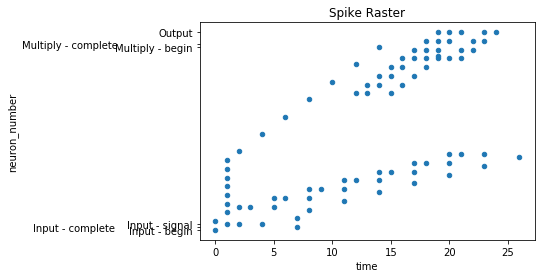

In [10]:
import matplotlib.pyplot as plot
num_elements=scaffold.graph.number_of_nodes()
print(num_elements)
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plot.yticks([0, 1, 2, num_elements-6, num_elements - 5, num_elements - 1], ['Input - begin', 'Input - complete                         ', 'Input - signal','Multiply - begin', 'Multiply - complete                        ', 'Output'])
plot.show()

Of course, these raster plots aren't really easy to interpret.  So we can instead convert the raster of the output node to a decimal number

In [11]:
num_elements=scaffold.graph.number_of_nodes()

# One way to plot the output of our Panda SNN outputs is to index a time and neuron number in a query string
#
# Here, we identify the when the start node of the last output adder fires to identify when to start looking at the last adder's output node
last_adder_begin=np.sum(result.query('neuron_number=='+str(num_elements)+'-6')['time'])
query_str=str(last_adder_begin)+' <= time and neuron_number ==' +str(num_elements-1)
query_str_in0=str(0)+' <= time and neuron_number ==' +str(2)


multiply_input=np.sum(2**(result.query(query_str_in0)['time']))
print('Multiply input: '+ str(multiply_input)+' times ' + str(alpha))

# We have to shift the output timing to the start node and by the bit-precision of the fraction (in this case 8 bits) 
multiply_output=np.sum(2**(result.query(query_str)['time']-last_adder_begin-8))
print('Multiply Output: '+ str(multiply_output))




Multiply input: 22.0 times 0.3125
Multiply Output: 6.875
